## Modelo P1 usando **XGBoost**

Notebook con entrenamiento del modelo XGBoost con el dataframe con datos de peleas

Autor: Mateo Turati

Descripción: Obtengo los datos de train, validación y test, esta vez de forma aleatoria. Creo dos modelos de XGBoostClassifier usando dos métodos de ajuste de hiperparámetros y estudio sus resultados.

* [Carga de los datos](#carga-de-los-datos)
* [Modelo Baseline](#modelo-baseline)
* [Transformaciones](#transformaciones)
* [Selección de variables](#selección-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparámetros)
* [Conclusiones](#conclusiones)

In [23]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Marca con un * al final las que ya estén solucionadas

#Solucionar:
#Me da un fallo al ejecutar en la celda, porque hay varialbles categoricas
#print("--- Entrenamiento usando ajuste de hiperparámetros con GridSeachCV ---")
#best_grid = train_xgboost_grid(X_train,y_train,X_val,y_val) *

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

#### CARGA DE DATOS

Cargo los datos de train y test. Los cuales ya tenemos guardados en la carpeta data. 

In [2]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..", "..", "data", "P1","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
0,Olivier Aubin-Mercier,Tony Sims,2015-08-23,LIGHTWEIGHT,False,Decision - Unanimous,300,3,0,0,...,2,0,1,0,0,0,0,0,1,1
1,Elvis Mutapcic,Anthony Smith,2016-12-03,MIDDLEWEIGHT,True,KO/TKO,207,2,0,1,...,0,0,1,1,1,0,0,1,1,1
2,Michael Johnson,Edward Faaloloto,2011-06-26,LIGHTWEIGHT,False,KO/TKO,282,1,1,0,...,0,0,0,0,0,1,0,0,1,0
3,Polyana Viana,Mallory Martin,2021-02-13,STRAWWEIGHT,False,Submission,198,1,0,0,...,3,1,0,0,0,0,1,2,2,0
4,Charles Jourdain,Nathaniel Wood,2022-09-03,FEATHERWEIGHT,True,Decision - Unanimous,300,3,0,0,...,1,3,1,3,0,1,1,0,5,1


In [3]:
ruta_val = os.path.join("..","..","..", "data", "P1","validation.parquet")
df_val = pd.read_parquet(ruta_val)
df_val.head()

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
0,Yaotzin Meza,Sergio Pettis,2014-06-07,BANTAMWEIGHT,True,Decision - Unanimous,300,3,0,0,...,1,0,0,2,1,0,0,1,1,0
1,Rob Kimmons,Dongi Yang,2011-03-03,MIDDLEWEIGHT,True,KO/TKO,287,2,0,1,...,2,0,1,0,2,0,2,0,0,1
2,Michel Pereira,Tristan Connelly,2019-09-14,WELTERWEIGHT,True,Decision - Unanimous,300,3,0,0,...,0,0,0,1,0,0,0,0,1,0
3,Punahele Soriano,Uros Medic,2025-01-18,WELTERWEIGHT,False,KO/TKO,31,1,1,0,...,0,0,1,0,1,1,1,2,2,0
4,Muslim Salikhov,Laureano Staropoli,2019-10-26,WELTERWEIGHT,False,Decision - Unanimous,300,3,0,0,...,0,0,1,2,0,0,1,0,0,1


In [4]:
ruta_test = os.path.join("..","..", "..","data", "P1","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
0,John Phillips,Khamzat Chimaev,2020-07-15,MIDDLEWEIGHT,True,Submission,72,2,0,0,...,0,1,0,0,0,0,3,0,1,0
1,Bob Cook,Tiki Ghosn,2000-03-10,LIGHTWEIGHT,False,Submission,89,2,0,0,...,1,0,0,0,0,0,0,1,0,0
2,Joshua Burkman,KJ Noons,2016-02-06,LIGHTWEIGHT,False,Decision - Unanimous,300,3,0,0,...,1,0,4,1,1,0,3,1,3,2
3,Tai Tuivasa,Greg Hardy,2021-07-10,HEAVYWEIGHT,False,KO/TKO,67,1,1,0,...,0,0,1,1,1,2,1,0,1,1
4,Georges St-Pierre,Josh Koscheck,2010-12-11,WELTERWEIGHT,False,Decision - Unanimous,300,5,0,0,...,2,3,8,5,1,1,1,1,0,3


In [5]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER","CATEGORY","METHOD","ROUND"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.627322
True     0.372678
Name: proportion, dtype: float64

In [7]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER","CATEGORY","METHOD","ROUND"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.633815
True     0.366185
Name: proportion, dtype: float64

Verificamos que los conjuntos tengan una proporción similar de la variable respuesta.

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.

Tan solo eliminamos algunas variables que vimos que tenían una importancia nula o baja para mejorar el coste computacional y variables no útiles que podrían generar problemas.

In [53]:
X_test = X_test.drop(columns=["TITLE_FIGHT","WOMEN"])
X_train = X_train.drop(columns=["TITLE_FIGHT","WOMEN"])
X_val = X_val.drop(columns=["TITLE_FIGHT","WOMEN"])

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

#### MODELO BASELINE

Creo un modelo simple el cual debería conseguir mejorar tras realizar los ajustes de hiperparámetros. Para este modelo usaré los hiperparámetros por defecto de XGBoost, sin tener en cuenta los ligeros desbalances de clases.

In [54]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [55]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_val)
y_val_prob = base.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.9583687340696686
F1-Score: 0.9415
AUC-ROC: 0.9934
Precisión: 0.9540
Sensibilidad: 0.9292
Log-loss: 0.10353431944437905


Vemos que los resultados sin ajuste de hiperparámetros son buenos, esto nos inidica que los datos son explicativos respecto a la variable respuesta y el modelo elegido funciona correctament. Aún así intentaremos mejorar las métricas usando las técnicas de ajuste de hiperparámetros

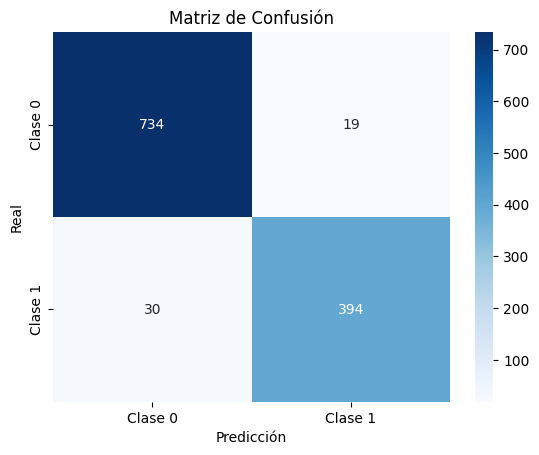

In [32]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.

En nuestro caso eliminamos algunas variables que no aportaban información al modelo para reducir el coste computacional.

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

In [34]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Cuadrícula de hiperparámetros con y sin ajuste de pesos
    param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [1, 3],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}

    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,  # Optimiza F1-macro
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_

In [35]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid = train_xgboost_grid(X_train,y_train,X_val,y_val)

-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'scale_pos_weight': np.float64(1.683284457478006), 'subsample': 0.7}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       753
        True       0.95      0.96      0.95       424

    accuracy                           0.97      1177
   macro avg       0.96      0.96      0.96      1177
weighted avg       0.97      0.97      0.97      1177



In [36]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_val)
y_val_prob = best_grid.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.9668649107901445
F1-Score: 0.9541
AUC-ROC: 0.9944
Precisión: 0.9529
Sensibilidad: 0.9552
Log-loss: 0.09388974088757099


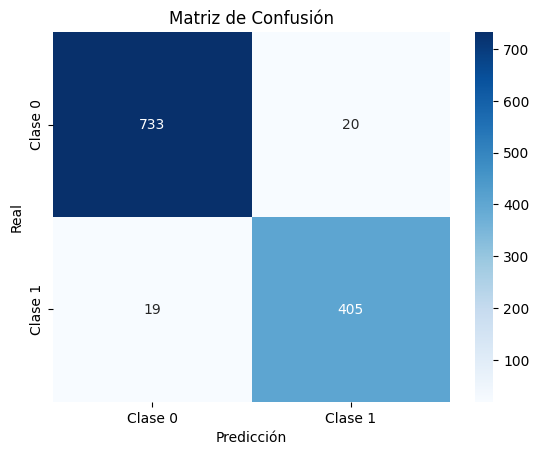

In [37]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [38]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

           Feature  Importance
46    SIG_STR_DIFF    0.096192
45         KD_DIFF    0.072426
41  STR_GROUND_A_x    0.054204
2             KD_B    0.045206
43  STR_GROUND_B_x    0.035674
..             ...         ...
30     STR_LEG_A_y    0.003410
26    STR_BODY_A_y    0.003386
32     STR_LEG_B_y    0.003262
10           REV_B    0.002010
55     TITLE_FIGHT    0.000000

[77 rows x 2 columns]


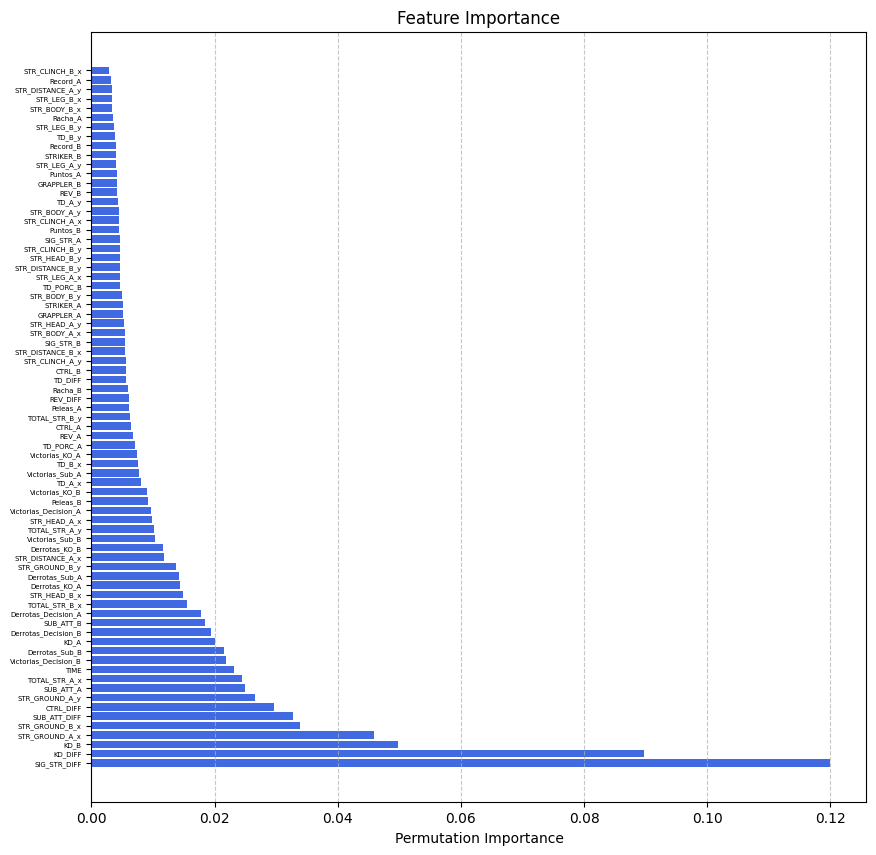

In [64]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [56]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 30, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=5,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return random_search.best_estimator_

In [58]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
best_random = train_xgboost_random(X_train,y_train,X_val,y_val)

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'subsample': np.float64(0.7), 'scale_pos_weight': 1, 'n_estimators': np.int64(200), 'min_child_weight': np.int64(7), 'max_depth': np.int64(15), 'learning_rate': np.float64(0.09444444444444444), 'gamma': np.float64(0.2), 'colsample_bytree': np.float64(0.9)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97       753
        True       0.97      0.93      0.95       424

    accuracy                           0.97      1177
   macro avg       0.97      0.96      0.96      1177
weighted avg       0.97      0.97      0.97      1177



In [59]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_val)
y_val_prob = best_random.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)

print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))


-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.9660152931180969
F1-Score: 0.9519
AUC-ROC: 0.9943
Precisión: 0.9706
Sensibilidad: 0.9340
Log-loss: 0.09701676306789361
[[741  12]
 [ 28 396]]


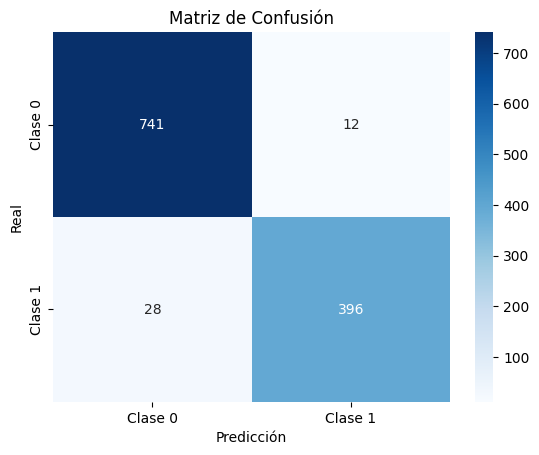

In [60]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [61]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

             Feature  Importance
46      SIG_STR_DIFF    0.119875
45           KD_DIFF    0.089807
2               KD_B    0.049729
41    STR_GROUND_A_x    0.045867
43    STR_GROUND_B_x    0.033915
..               ...         ...
27      STR_BODY_B_x    0.003274
31       STR_LEG_B_x    0.003269
34  STR_DISTANCE_A_y    0.003268
55          Record_A    0.003196
39    STR_CLINCH_B_x    0.002816

[75 rows x 2 columns]


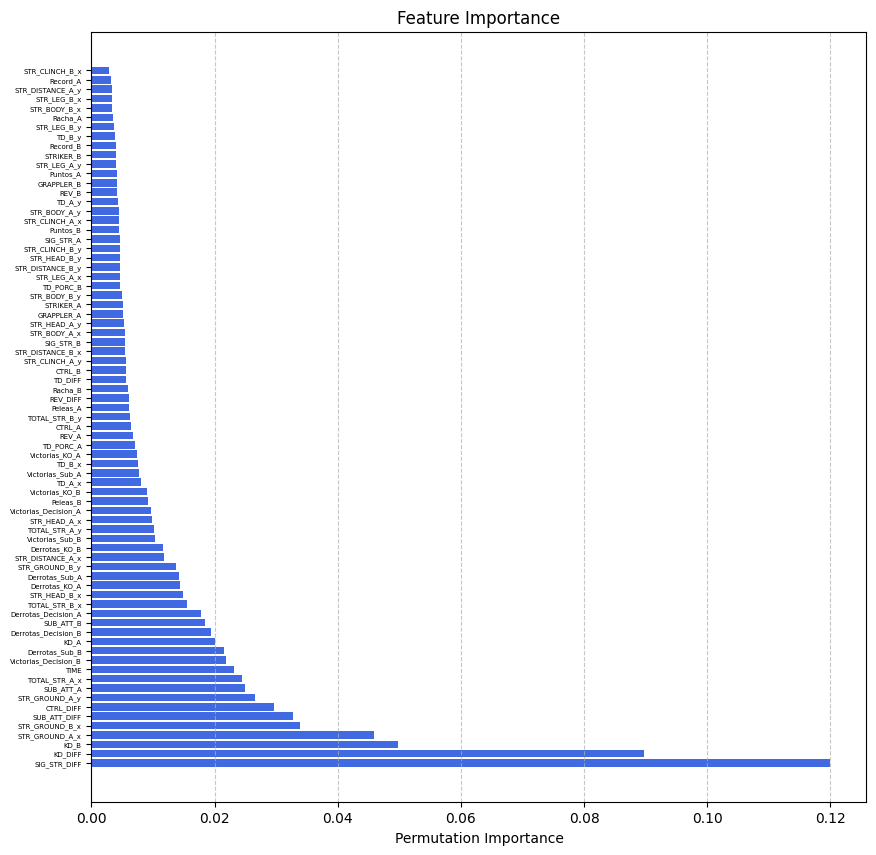

In [63]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### CONCLUSIONES

En este caso RandomizedSearchCV y GridSearchCV llegaron a los mismos resultados, esto significa que la combinación óptima que encuentra la búsqueda en rejilla también se encuentra aleatoriamente. Tras el ajuste de hiperparámetros hemos conseguido mejorar las métricas del modelo base, las cuales ya eran bastante buenas, lo que nos indica que el ajuste de hiperparámetros ha sido correcto.

Como conclusión podemos decir que el modelo funciona bastante bien consiguiendo realizar una gran tasa de aciertos, dando mucha impoortancia a variables que creamos manualmente como las diferencias en ciertos aspectos de la pelea. Uno de los puntos fuertes de este modelo es capturar relaciones no lineales, esto puede hacer que las métricas sean mejores ya que tiene en cuenta las relaciones entre variables